# Avance de Proyecto - Investigación

Integrantes:
> Juan Carlos Herrera

> Steven Jimenez Bustamante



## Clasificación de imágenes (Celulas sin Parásitos vs Celulas con Parásitos)

Background:

Los parásitos intracelulares son microparásitos que son capaces de crecer y reproducirse dentro de las células de un huésped. Algunos de estos parácitos son patogénicos, lo que quiere decir que puede provocar enfermedades en las células y en el organismo portador. Por mencionar algunos de estos parásitos patogénicos, se encuentran Salmonella Typhi, Staphylococcus aureus​, Clamidia, entre otros. 

Es por esto que confirmar la presencia o ausencia de un parásito en una célula es de suma importancia para prevenir enfermedades. 

Para este ejercicio, utilizaremos un dataset de imagenes con presencia de parásitos intracelular y también de imágenes con ausencia de parásitos intracelulares. Este dataset se obtuvo de la siguiente página:

https://www.kaggle.com/brsdincer/cell-images-parasitized-or-not

A continuación se describen los dos escenarios (etiquetas):
> Célula con Parásito (**Infectada**)

> Célula sin Parásito (**No Infectada**)


Nuestro problema consiste en clasificar una imagen en dos escenarios, celula **Infectada** y célula **No Infectada**. 

La propuesta de estrategia para abordar este problema de clasificación es el siguiente:

1. Preprocesar la imagenes
2. Decidir cuales features de las imágenes son relevantes para el modelo de clasificación
3. Definir el modelo de clasificación

>> 3.1 Entrenar una red neuronal pre-entrenada mediante Fast AI y ResNet34

>> 3.2 Crear y entrenar una red neuronal desde cero
>>> Se harán pruebas con varias capas ocultas de redes neuronales, y en base a los datos de accuracy, se seleccionará el mejor modelo de red neuronal desde cero. 

4. Se validará cual es el método más eficiente para la clasificación de imagenes. Model entrenado desde cero VS Modelo Pre-entrenado


## Creacion de una CNN para clasificar imagenes desde 0


In [ ]:
#Importación de librerías
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.python.keras.layers import  Convolution2D, MaxPooling2D
from tensorflow.python.keras import backend as K
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras

# Librerias de ayuda
import cv2
import os
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [ ]:

# Creacion del acceso a google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from IPython import display


Mounted at /content/drive


Célula sin Parásito (no Infectada)


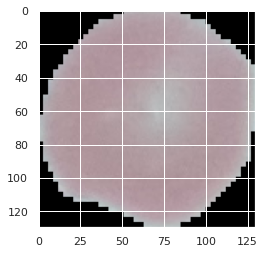

In [ ]:
# Se muestran ejemplos de celulas infectadas y no Infectadas
print("Célula sin Parásito (no Infectada)")
image = plt.imread('/content/drive/My Drive/Colab Notebooks/cell_images/test/uninfected/C241NThinF_IMG_20151207_124608_cell_171.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))



Célula con Parásito (Infectada)


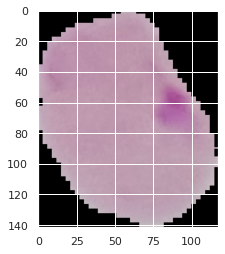

In [ ]:
print("Célula con Parásito (Infectada)")
image = plt.imread('/content/drive/My Drive/Colab Notebooks/cell_images/test/parasitized/C189P150ThinF_IMG_20151203_141901_cell_82.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
K.clear_session() #Borrar sesiones remanentes

In [ ]:
# Se definen los directorios que contienen las imagenes para train y test
Entrenamiento = '/content/drive/My Drive/Colab Notebooks/cell_images/train'
Validacion = '/content/drive/My Drive/Colab Notebooks/cell_images/test'

    

In [ ]:
# a continuancion definiremos ciertos parametros que van ser de utilidad durante la construccion de las diferentes capa de la CNN
epochs=10 ## define la cantidad de epochs de cada red que decidamos incorporar
length, width= 100, 100 # se define el tamano de 100X100 para las imagenes 
Inputshape = 100, 100,3 # Se define el tamano para la red y ademas que es de 3 canales RGB o a color en resumidas palabras
batch_size = 32 # tamano de los bactches a procesar en cada CNN

# numero de veces que se va a procesar la informacion en este caso vamos a definir 
# num_samples de training 24987 / batch_size 32
steps = 780
# numero de veces que se va a procesar la informacion en este caso vamos a definir 
# num_samples de validacio 2600/ batch_size 32
validation_steps = 81

## se definen los filtros a usar en cada capa de nuestra CNN
filtroConv1 = 32
filtroConv2 = 64
filtroConv3 = 128
filtroConv4 = 256
###
filtro1 = (3, 3)
filtro2 = (3, 3)
filtro3 = (2, 2)
filtro4 = (2, 2)
tamano_pool = (2, 2)
clases = 2 # se definen la cantidad de clases del modelo en este caso 2 con parasito y sin parasito
lr = 0.002 # se define el learning rate del modelo

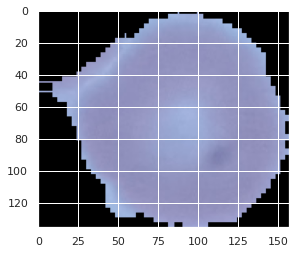

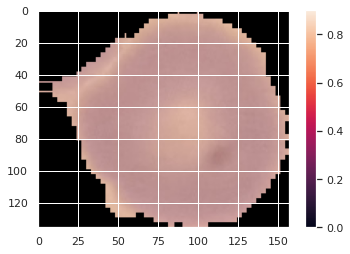

(136, 157, 3)

In [ ]:
## a continuacion se pplotea una imagen de ejemplo para ver su dimension y colores
image = plt.imread('/content/drive/My Drive/Colab Notebooks/cell_images/test/uninfected/prueba.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(image)
plt.colorbar()
plt.grid(True)
plt.show()
image.shape

### Preparacion y procesado de imagenes 


In [ ]:
# Definimos en una variable los parametro a configurar y se realiza el ajuste de las imagenes RGB para obtener valores entre 0 y 1...
# Zoom range del 10% , pero dependiendo del accuracy se puede variar para obtener un resultado diferente 

set_entrenamiento = ImageDataGenerator(rescale=1. / 255,shear_range=0.1,zoom_range=0.1,horizontal_flip=True)
set_validacion = ImageDataGenerator(rescale=1. / 255, zoom_range=0.1, shear_range=0.1 ,horizontal_flip=True)


In [ ]:
##Se utiliza la funcion flow from directory para procesar las imagenes del directorio deseado 
#con todos los parametros con el que sera preprocesadas las imagenes 
entrenamiento_procesado = set_entrenamiento.flow_from_directory(Entrenamiento,target_size=(length, width),
    batch_size=batch_size,color_mode='rgb',class_mode='categorical')

Found 24987 images belonging to 2 classes.


In [ ]:
#Se realiza un proceso similir de preprocesado para las imagenes de validacion
validacion_procesado = set_validacion.flow_from_directory(Validacion,target_size=(length, width),
    batch_size=batch_size, color_mode='rgb',class_mode='categorical')


Found 2600 images belonging to 2 classes.


## Creacion de la CNN


In [ ]:
## Se define CNN como secuencial para que las capas se ejecuten en secuencia 
## se utiliza la capa convolution2d de la libreria Keras por su performance en procesado de imagenes
## primer capa CNN
# se aplica una capa de pooling luego de
Celulascnn = Sequential()
Celulascnn.add(Convolution2D(filtroConv1,filtro1, padding ="same",input_shape=Inputshape , activation='relu'))
Celulascnn.add(MaxPooling2D(pool_size=tamano_pool))

In [ ]:
#segunda capa de CNN
Celulascnn.add(Convolution2D(filtroConv3,filtro2, padding ="same",activation='relu'))
Celulascnn.add(MaxPooling2D(pool_size=tamano_pool))

In [ ]:
#tercera capa de CNN
Celulascnn.add(Convolution2D(filtroConv3, filtro3, padding ="same",activation='relu'))
Celulascnn.add(MaxPooling2D(pool_size=tamano_pool))

In [ ]:
#cuarta capa de la CNN
Celulascnn.add(Convolution2D(filtroConv4,filtro4, padding ="same",activation='relu'))
Celulascnn.add(MaxPooling2D(pool_size=tamano_pool))

In [ ]:
### se usa flatten par aplanar el modelo,una nueva capa de procesado y dropout del 50% para prevenir el overfitting  y 
# luego una nueva capa de procesado y para finalizar softmax como capa de salida del modelo
Celulascnn.add(Flatten())
Celulascnn.add(Dense(128, activation='relu'))
Celulascnn.add(Dropout(0.5))
Celulascnn.add(Dense(clases, activation='softmax'))

### Entrenamiento del modelo

In [ ]:
# se utliza el optimizador Adam para optimizacion y compilacion del modelo
opt = keras.optimizers.Adam(learning_rate=lr)
Celulascnn.compile(loss='categorical_crossentropy',optimizer = opt, metrics=['accuracy'])

In [ ]:

grafico = Celulascnn.fit(entrenamiento_procesado,steps_per_epoch=steps,epochs=epochs, validation_data=validacion_procesado,validation_steps=validation_steps)

Epoch 1/10
780/780 [==============================] - 9330s 12s/step - loss: 0.3802 - accuracy: 0.8089 - val_loss: 0.1886 - val_accuracy: 0.9464
Epoch 2/10
780/780 [==============================] - 722s 925ms/step - loss: 0.1616 - accuracy: 0.9536 - val_loss: 0.1533 - val_accuracy: 0.9529
Epoch 3/10
780/780 [==============================] - 737s 944ms/step - loss: 0.1507 - accuracy: 0.9558 - val_loss: 0.1518 - val_accuracy: 0.9510
Epoch 4/10
780/780 [==============================] - 735s 942ms/step - loss: 0.1447 - accuracy: 0.9568 - val_loss: 0.1417 - val_accuracy: 0.9525
Epoch 5/10
780/780 [==============================] - 738s 946ms/step - loss: 0.1416 - accuracy: 0.9561 - val_loss: 0.1454 - val_accuracy: 0.9502
Epoch 6/10
780/780 [==============================] - 740s 948ms/step - loss: 0.1385 - accuracy: 0.9576 - val_loss: 0.1367 - val_accuracy: 0.9533
Epoch 7/10
780/780 [==============================] - 736s 943ms/step - loss: 0.1352 - accuracy: 0.9584 - val_loss: 0.1500 - 

In [ ]:
# imprimimos un remunen del modelo para ver su comportamiento
print(Celulascnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, None, None, 32)    896       
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, None, None, 32)    0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, None, None, 128)   36992     
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, None, None, 128)   0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, None, None, 128)   65664     
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, None, None, 128)   0         
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, None, None, 256)   1

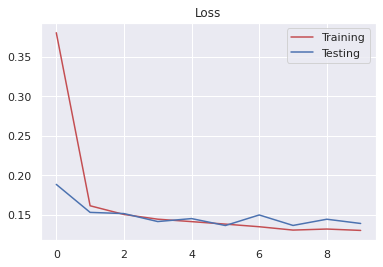

In [ ]:
#Se realiza un grafico para poder visualmente el loss del modelo entrenado
plt.figure(0)
plt.title("Loss")
plt.plot(grafico.history['loss'], 'r', label='Training')
plt.plot(grafico.history['val_loss'], 'b', label='Testing')
plt.legend()
plt.show()

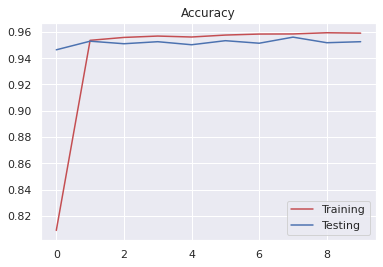

In [ ]:
#se realiza un grafico para ver el comportamiento del accuracy durante los epochs
plt.figure(1)
plt.title("Accuracy")
plt.plot(grafico.history['accuracy'], 'r', label='Training')
plt.plot(grafico.history['val_accuracy'], 'b', label='Testing')
plt.legend()
plt.show()

In [ ]:
# Se genera una funcion para almacenar o crear un directorio para guardar el modelo
target_dir = '/content/drive/My Drive/Colab Notebooks/cell_images/modelo'
if not os.path.exists(target_dir):
    os.mkdir(target_dir)
Celulas_cnn.save('/content/drive/My Drive/Colab Notebooks/cell_images/modelo/modelo.h5')
Celulas_cnn.save_weights('/content/drive/My Drive/Colab Notebooks/cell_images/modelo/pesos.h5')

## Seccion de prediccion y prueba


In [ ]:
longitud, altura = 100, 100
modelo = '/content/drive/My Drive/Colab Notebooks/cell_images/modelo/modelo.h5'
pesos_modelo = '/content/drive/My Drive/Colab Notebooks/cell_images/modelo/pesos.h5'
cnn = load_model(modelo)
cnn.load_weights(pesos_modelo)

def predict(file):
  x = load_img(file, target_size=(longitud, altura))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  array = cnn.predict(x)
  result = array[0]
  answer = np.argmax(result)
  if answer == 0:
    print("pred: celula con parasitos")
  elif answer == 1:
    print("pred:celula no infectada")
  return answer

pred:celula no infectada


1

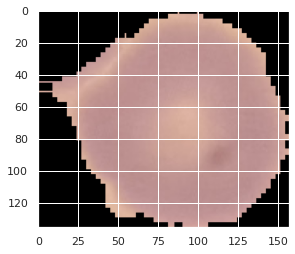

In [ ]:
#Prueba de una imagen para ver el resultado
path= '/content/drive/My Drive/Colab Notebooks/cell_images/test/uninfected/C3thin_original_IMG_20150608_162835_cell_101.png'
plt.imshow(image)
predict(path)

# Construccion de modelo con CNN preentrenada  RESNET34
